In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datasets import MNISTDataset
import os

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose,concatenate, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model

170500096/170498071 [==============================] - 4s 0us/step


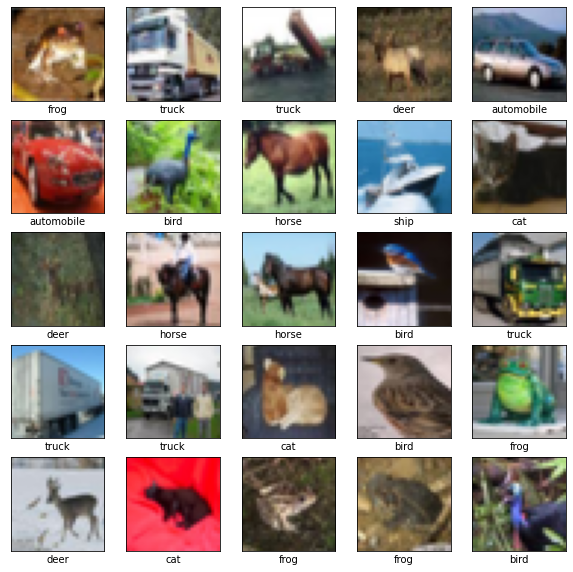

Train data Shape:(50000, 32, 32, 3)
Train label shape:(50000, 1)


In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

print("Train data Shape:"+ str(train_images.shape)) #50000 images of 32X32 pixels 3 channels(RGB)
print("Train label shape:"+ str(train_labels.shape))
data = tf.data.Dataset.from_tensor_slices(
    (train_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, train_labels.reshape((-1,)).astype(np.int32)))
data = data.shuffle(buffer_size=50000).batch(128).repeat()

# note: we batch the test data, but do not shuffle/repeat
test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, test_labels.reshape((-1,)).astype(np.int32))).batch(128)


In [0]:
@tf.function
def loss_fn(output, original):
  reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(output, original)))
  return reconstruction_error

logdir = os.path.join("logs", "mnist")
recorder = tf.summary.create_file_writer(os.path.join(logdir, "train"))

def write_summary(original,reconstructed,xent,step,max_output):
  with recorder.as_default():
    tf.summary.scalar('loss', xent, step=step)
    tf.summary.image('original', original, max_outputs=max_output, step=step) 
    tf.summary.image('reconstructed', reconstructed, max_outputs=max_output, step=step)    

In [5]:
encoding_dim = 100


n_f = 32
input_shape = (32,32,3)
input_img = Input(shape=input_shape)
conv1 = Conv2D(filters= n_f, kernel_size=(2,2), padding='same', activation='relu')(input_img)
max1 = MaxPooling2D(2,2)(conv1)
conv2 = Conv2D(filters= n_f * 2, kernel_size=(2,2), padding='same', activation='relu')(max1)
max2  = MaxPooling2D(2,2)(conv2)
conv3 = Conv2D(filters= n_f * 4 , kernel_size=(2,2), padding='same', activation='relu')(max2)
max3 = MaxPooling2D(2,2)(conv3)
flat = Flatten()(max3)
latent = Dense(encoding_dim)(flat)

encoder = Model(input_img, latent)

latentInputs = Input(shape=(encoding_dim,))
dense = Dense(2048)(latentInputs)
conv_out = Reshape((4, 4, 128))(dense)
up1 = UpSampling2D()(conv_out)
conv4 =Conv2D(filters= n_f * 2, kernel_size=(2,2), padding='same', activation='relu')(up1)
up2 = UpSampling2D()(conv4)
conv5 = Conv2D(filters= n_f, kernel_size=(2,2), padding='same', activation='relu')(up2)
up3 = UpSampling2D()(conv5)     
decoded = Conv2D(filters= 3, kernel_size=(2,2), padding='same', activation='sigmoid')(up3)

decoder = Model(latentInputs, decoded)

cnn_autoencoder = Model(input_img, decoder(encoder(input_img)))
cnn_autoencoder.summary()

# encoder = Model(cnn_autoencoder.input, cnn_autoencoder.layers[8].output)

# decoder_input = Input(shape=(encoding_dim,))
# decoder = Model(latentInputs, cnn_autoencoder.layers[-1].output)



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
model (Model)                (None, 100)               246468    
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         248291    
Total params: 494,759
Trainable params: 494,759
Non-trainable params: 0
_________________________________________________________________


In [0]:
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def plotAccuracies(history):  
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='upper right')
    plt.show()    

def run_model(model):
  model.compile(optimizer='adam',loss=loss_fn,metrics=['accuracy'])
  history = model.fit(train_images, train_images, epochs=10, batch_size= 128, 
                    validation_data=(test_images, test_images))
  plotLosses(history)
  plotAccuracies(history)  

def test(model):
  decoded_imgs = model.predict(test_images)

  n = 10  
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Epoch 1/10
391/391 [==============================] - 4s 11ms/step - loss: 0.0213 - accuracy: 0.5833 - val_loss: 0.0142 - val_accuracy: 0.6389
Epoch 2/10
391/391 [==============================] - 4s 11ms/step - loss: 0.0128 - accuracy: 0.6947 - val_loss: 0.0119 - val_accuracy: 0.7186
Epoch 3/10
391/391 [==============================] - 4s 11ms/step - loss: 0.0112 - accuracy: 0.7252 - val_loss: 0.0111 - val_accuracy: 0.7352
Epoch 4/10
391/391 [==============================] - 4s 11ms/step - loss: 0.0104 - accuracy: 0.7377 - val_loss: 0.0100 - val_accuracy: 0.7443
Epoch 5/10
391/391 [==============================] - 4s 11ms/step - loss: 0.0098 - accuracy: 0.7449 - val_loss: 0.0095 - val_accuracy: 0.7504
Epoch 6/10
391/391 [==============================] - 4s 11ms/step - loss: 0.0093 - accuracy: 0.7493 - val_loss: 0.0092 - val_accuracy: 0.7514
Epoch 7/10
391/391 [==============================] - 4s 11ms/step - loss: 0.0089 - accuracy: 0.7535 - val_loss: 0.0087 - val_accuracy: 0.7531

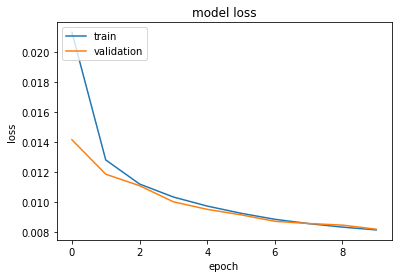

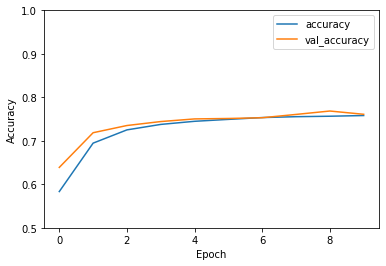

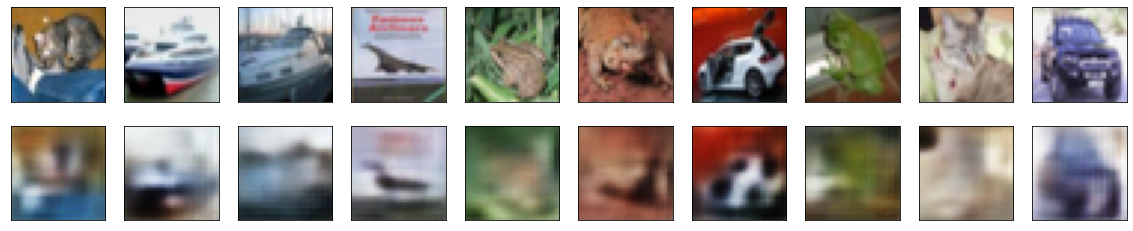

In [7]:
input_shape = (32,32,3)
# model = cnn_autoencoder(input_shape)
run_model(cnn_autoencoder)
test(cnn_autoencoder)

In [0]:
def print_generatedImage(no_of_images, imgs):
  n = no_of_images  
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display reconstruction
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

In [17]:
#To check how encoded_dims vary
encoded_dims = encoder.predict(test_images)
encoded_dims.shape
# print(np.amin(encoded_dims))
# print(np.amax(encoded_dims))

(10000, 100)

In [0]:
num_examples_to_generate = 10
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, encoding_dim])

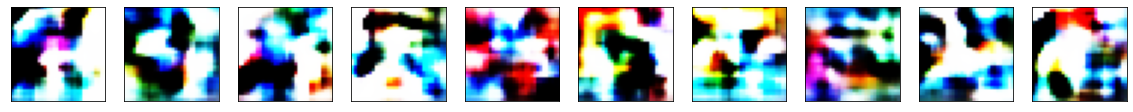

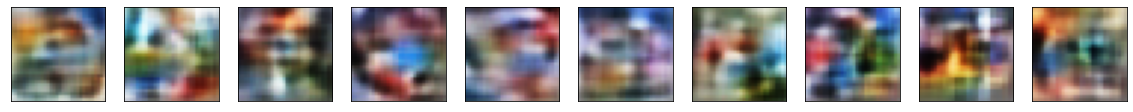

In [19]:
random_vector_for_generation = tf.random.uniform(
    shape=[num_examples_to_generate, encoding_dim],
    minval=np.amin(encoded_dims),
    maxval=np.amax(encoded_dims))

decoded_imgs = decoder.predict(random_vector_for_generation)
print_generatedImage(num_examples_to_generate,decoded_imgs)

random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, encoding_dim],
    mean=np.mean(encoded_dims),
    stddev=np.std(encoded_dims))

decoded_imgs = decoder.predict(random_vector_for_generation)
print_generatedImage(num_examples_to_generate,decoded_imgs)